In [1]:
import os
import datetime
import sklearn.preprocessing as pp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import lightgbm as lgbm
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier


mpl.rcParams['axes.grid'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
df = pd.read_csv('1hour_m.csv')

Text(0.5, 1.0, 'Time of Year signal')

Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


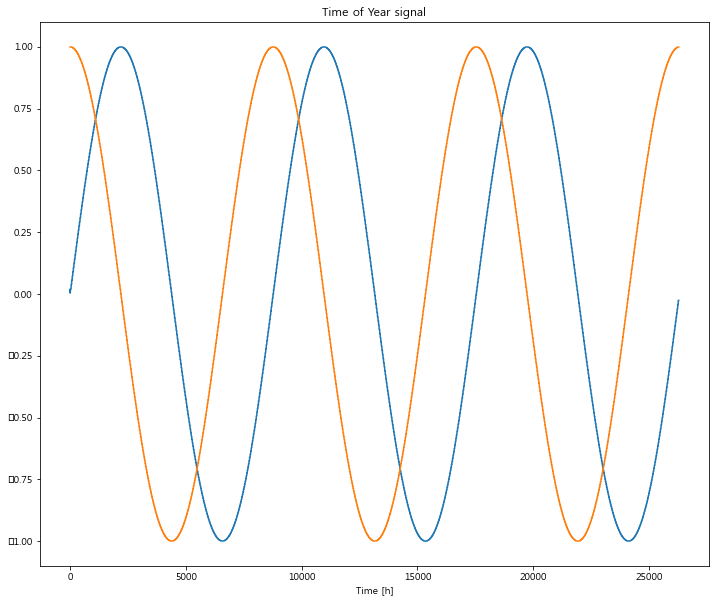

In [3]:
plt.plot(np.array(df['Year sin'])[::24])
plt.plot(np.array(df['Year cos'])[::24])
plt.xlabel('Time [h]')
plt.title('Time of Year signal')

###### 변환한 값으로 그래프를 그려보면 아래와 같다.

의미 : 매 주기(일 혹은 년) 마다 

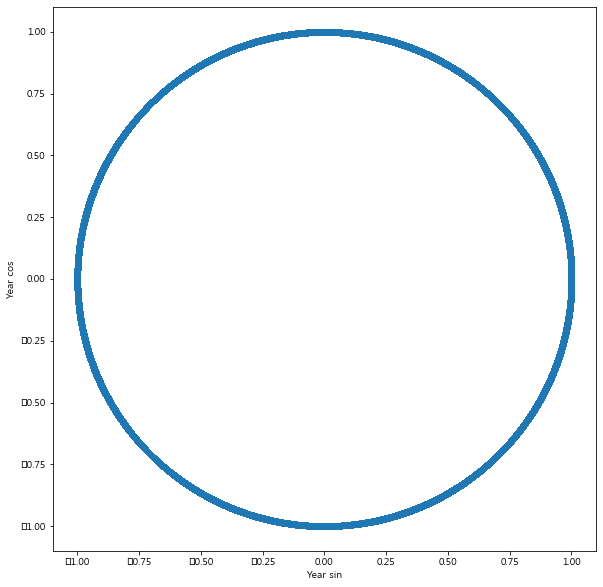

In [4]:
df.plot.scatter('Year sin','Year cos').set_aspect('equal');

In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[:420480]
val_df = df[420480:]

num_features = df.shape[1]

In [6]:
train_y = train_df['class']
val_y = val_df['class']

In [7]:
train_df.drop('class', axis=1, inplace=True)
val_df.drop('class', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
target_col = ['traffic','velocity','sight','views','publish']

In [9]:
train_mean = train_df[target_col].mean()
train_std = train_df[target_col].std()

In [10]:
train_df[target_col] = (train_df[target_col] - train_mean) / train_std
val_df[target_col] = (val_df[target_col] - train_mean) / train_std


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# lgbm 모델링

In [11]:
scale_pos_weight = df.shape[0]/df['class'].sum() - 1

In [13]:
# d_train = lgbm.Dataset(train_df, label=train_y)
# d_val = lgbm.Dataset(val_df, label=val_y)

# params = {
#     'learning_rate' : 0.01,
#     'boosting_type' :'dart',
#     'objective' :'binary',
#     'metric' : ['binary_logloss', 'auc'],
#     'scale_pos_weight' : scale_pos_weight,
#     'num_leaves' : 511,
#     'max_depth' : -1,
#     'verbose' : 0}
    
my_model = XGBClassifier(scale_pos_weight= scale_pos_weight, n_estimators= 1000, eval_metric='auc', boosting_type='dart')
my_model.fit(train_df, train_y, eval_set = [(val_df, val_y)], early_stopping_rounds=100)


[19:23:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { boosting_type } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.62307
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.63288
[2]	validation_0-auc:0.63604
[3]	validation_0-auc:0.63838


KeyboardInterrupt: 

### parameter 조정

In [12]:
import xgboost as xgb
dtrain = xgb.DMatrix(train_df, label=train_y)
dtest = xgb.DMatrix(val_df, label=val_y)

from sklearn.metrics import mean_absolute_error

import numpy as np

# "Learn" the mean from the training data
mean_train = np.mean(train_y)

# Get predictions on the test set
baseline_predictions = np.ones(val_y.shape) * mean_train

# Compute auc
auc_baseline = mean_absolute_error(val_y, baseline_predictions)
print("Baseline auc is {:.2f}".format(auc_baseline))

Baseline auc is 0.24


In [13]:
print("Best AUC: {:.2f} with {} rounds".format(
                 my_model.best_score,
                 my_model.best_iteration+1))

NameError: name 'my_model' is not defined

In [19]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'nthread' : 6,
    'scale_pos_weight' : scale_pos_weight,
    'objective':'binary:logistic',
}

In [20]:
params['eval_metric'] = "auc"

In [21]:
num_boost_round = 999

In [22]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.61932
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.62636
[2]	Test-auc:0.63574
[3]	Test-auc:0.63806
[4]	Test-auc:0.64028
[5]	Test-auc:0.64183
[6]	Test-auc:0.64184
[7]	Test-auc:0.64227
[8]	Test-auc:0.64316
[9]	Test-auc:0.64310
[10]	Test-auc:0.64327
[11]	Test-auc:0.64343
[12]	Test-auc:0.64359
[13]	Test-auc:0.64400
[14]	Test-auc:0.64407
[15]	Test-auc:0.64396
[16]	Test-auc:0.64372
[17]	Test-auc:0.64365
[18]	Test-auc:0.64369
[19]	Test-auc:0.64367
[20]	Test-auc:0.64357
[21]	Test-auc:0.64339
[22]	Test-auc:0.64340
[23]	Test-auc:0.64336
[24]	Test-auc:0.64337
Stopping. Best iteration:
[14]	Test-auc:0.64407



In [23]:
print("Best AUC: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best AUC: 0.64 with 15 rounds


In [24]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)

In [25]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

# Define initial best params and auc
max_auc = float(0)
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    
    # Update best auc
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tauc {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc >= max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, auc: {}".format(best_params[0], best_params[1], max_auc))

CV with max_depth=9, min_child_weight=5
	auc 0.624653 for 8 rounds
CV with max_depth=9, min_child_weight=6
	auc 0.6250296000000001 for 11 rounds
CV with max_depth=9, min_child_weight=7
	auc 0.6247467999999999 for 8 rounds
CV with max_depth=10, min_child_weight=5
	auc 0.6205914 for 8 rounds
CV with max_depth=10, min_child_weight=6
	auc 0.6204042 for 8 rounds
CV with max_depth=10, min_child_weight=7
	auc 0.6206478000000001 for 10 rounds
CV with max_depth=11, min_child_weight=5
	auc 0.6162002 for 7 rounds
CV with max_depth=11, min_child_weight=6
	auc 0.6170481999999999 for 6 rounds
CV with max_depth=11, min_child_weight=7
	auc 0.61761 for 6 rounds
Best params: 9, 6, auc: 0.6250296000000001


In [26]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_auc = float(0)
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tauc {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc >= min_auc:
        min_auc = mean_auc
        best_params = (subsample,colsample)
print("Best params: {}, {}, auc: {}".format(best_params[0], best_params[1], max_auc))

CV with subsample=1.0, colsample=1.0
	auc 0.6250296000000001 for 11 rounds
CV with subsample=1.0, colsample=0.9
	auc 0.6237796 for 8 rounds
CV with subsample=1.0, colsample=0.8
	auc 0.6246416000000001 for 12 rounds
CV with subsample=1.0, colsample=0.7
	auc 0.6240164 for 11 rounds
CV with subsample=0.9, colsample=1.0
	auc 0.6232006 for 10 rounds
CV with subsample=0.9, colsample=0.9
	auc 0.6229954 for 6 rounds
CV with subsample=0.9, colsample=0.8
	auc 0.6232396 for 10 rounds
CV with subsample=0.9, colsample=0.7
	auc 0.6221140000000001 for 9 rounds
CV with subsample=0.8, colsample=1.0
	auc 0.6228398 for 9 rounds
CV with subsample=0.8, colsample=0.9
	auc 0.6228294000000001 for 6 rounds
CV with subsample=0.8, colsample=0.8
	auc 0.623066 for 6 rounds
CV with subsample=0.8, colsample=0.7
	auc 0.6226176000000001 for 10 rounds
CV with subsample=0.7, colsample=1.0
	auc 0.6218096 for 8 rounds
CV with subsample=0.7, colsample=0.9
	auc 0.6214464 for 9 rounds
CV with subsample=0.7, colsample=0.8
	au

TypeError: 'NoneType' object is not subscriptable

In [27]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

In [28]:
%time
# This can take some time…
min_auc = float(0)
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta

    # Run and time CV
    %time 
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['auc'],
        early_stopping_rounds=10
    )

    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tauc {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc >= min_auc:
        min_auc = mean_auc
        best_params = eta
print("Best params: {}, auc: {}".format(best_params, max_auc))

Wall time: 0 ns
CV with eta=0.3
Wall time: 0 ns
	auc 0.6250296000000001 for 11 rounds

CV with eta=0.2
Wall time: 0 ns
	auc 0.6267777999999999 for 17 rounds

CV with eta=0.1
Wall time: 0 ns
	auc 0.6291271999999999 for 36 rounds

CV with eta=0.05
Wall time: 0 ns
	auc 0.6299316000000001 for 77 rounds

CV with eta=0.01
Wall time: 0 ns
	auc 0.6303946 for 345 rounds

CV with eta=0.005
Wall time: 0 ns
	auc 0.6304304000000001 for 707 rounds

Best params: None, auc: 0.6250296000000001


In [29]:
params['eta'] = 0.01

# params
# {'colsample_bytree': 0.8,
#  'eta': 0.3,
#  'eval_metric': 'auc',
#  'max_depth': 11,
#  'min_child_weight': 5,
#  'objective':'binary:logistic',
#  'subsample': 1.0}

In [30]:
dtrain = xgb.DMatrix(train_df, label=train_y)
dtest = xgb.DMatrix(val_df, label=val_y)

In [ ]:
# params = {'max_depth': 9,
#  'min_child_weight': 6,
#  'eta': 0.01,
#  'subsample': 1,
#  'colsample_bytree': 1,
#  'nthread': 6,
#  'scale_pos_weight': 6.115332979839574,
#  'objective': 'binary:logistic',
#  'eval_metric': 'auc'}

In [ ]:
model_low = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=50
)

print("Best auc: {:.2f} in {} rounds".format(model_low.best_score, model_low.best_iteration+1))

In [ ]:
num_boost_round = model_low.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)


In [31]:
params

{'max_depth': 9,
 'min_child_weight': 6,
 'eta': 0.01,
 'subsample': 1,
 'colsample_bytree': 1,
 'nthread': 6,
 'scale_pos_weight': 6.1150622186622146,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [32]:
xg_cl =XGBClassifier(booster='gbtree', 
                    max_depth=9, 
                    min_child_weight=6, 
                    n_estimators=1000, 
                    nthread=6,
                    eta = 0.01,
                    eval_metrics = ['auc'],
                    scale_pos_weight = scale_pos_weight,
                    objective='binary:logistic', 
                    random_state=2, 
                    silent= True)

xg_cl.fit(train_df, train_y, eval_set=[(val_df, val_y)],
             early_stopping_rounds=50)

# Predict the labels of the test set: preds
xg_cl_preds = xg_cl.predict(val_df)

[00:13:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { eval_metrics, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.43102
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.43158
[2]	validation_0-error:0.49715
[3]	validation_0-error:0.49703
[4]	validation_0-error:0.49061
[5]	validation_0-error:0.48948
[6]	validation_0-error:0.49076
[7]	validation_0-error:0.48703
[8]	validation_0-error:0.48586
[9]	validation_0-error:0.48734
[10]	validation_0-error:0.48681
[11]	validation_0-error:0.48629
[12]	validation_0-error:0.48738
[13]	validation_0-error:0.48583
[14]	validation_0-error:0.48540
[15]	validation_0-error:0.48535
[16]	validation_0-error:0.48431
[1

In [ ]:
# convert into binary values
for i in range(0, val_df.shape[0]):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, xg_cl_preds)

#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(xg_cl_preds, val_y)

In [ ]:
cm

In [ ]:
accuracy

In [33]:
precision_score(val_y, xg_cl_preds), recall_score(val_y, xg_cl_preds), f1_score(val_y, xg_cl_preds)

(0.18898536545595368, 0.6273130137681404, 0.29046481575752825)

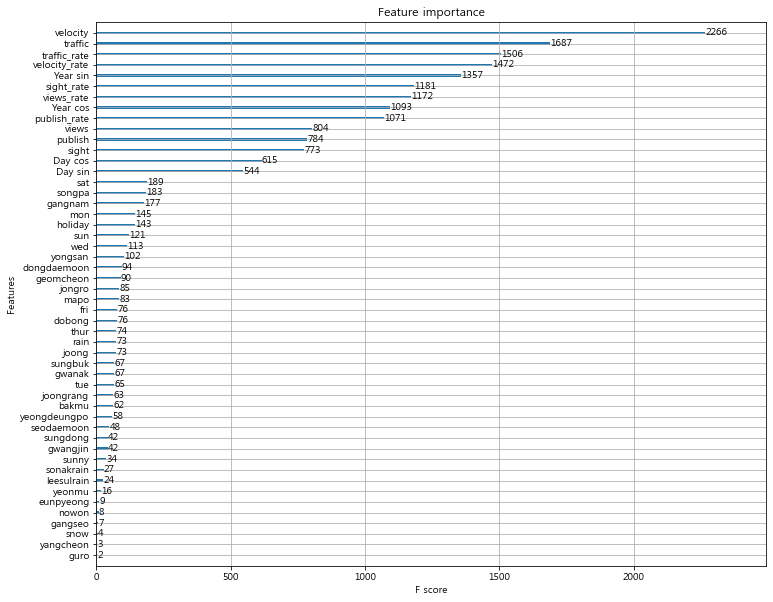

In [34]:
xgb.plot_importance(xg_cl, importance_type = 'weight')

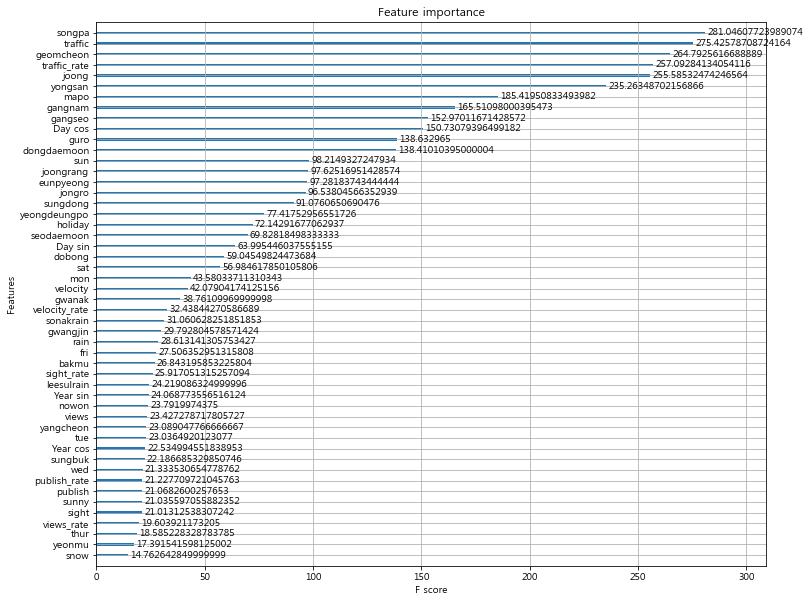

In [35]:
xgb.plot_importance(xg_cl, importance_type = 'gain')

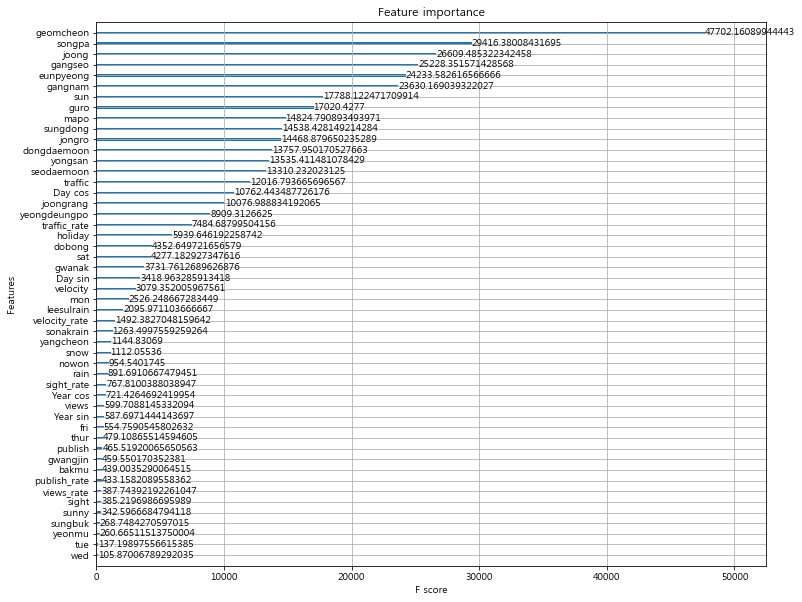

In [36]:
xgb.plot_importance(xg_cl, importance_type = 'cover')

In [37]:
booster = xg_cl.get_booster()
model_bytearray = booster.save_raw()[4:]


def myfun(self=None):
    return model_bytearray


booster.save_raw = myfun

# Shap explainer initilization
shap_ex = shap.TreeExplainer(booster)

In [ ]:
explainer = shap.TreeExplainer(xg_cl)
# shap_values = shap.TreeExplainer(model).shap_values(val_df)

In [38]:
shap_values = shap.TreeExplainer(xg_cl).shap_values(val_df)

Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


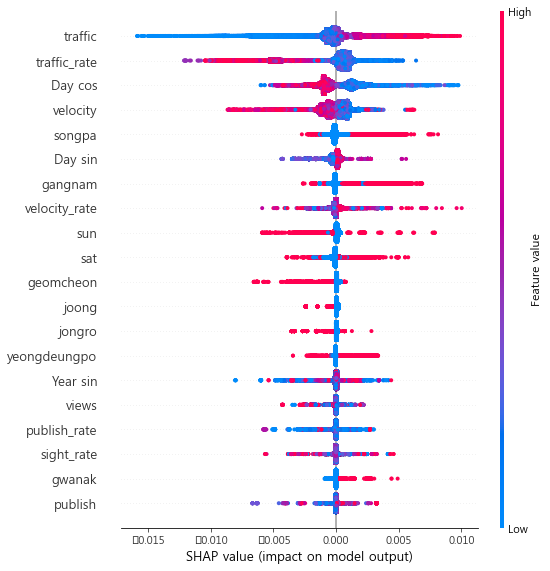

In [39]:
shap.summary_plot(shap_values, val_df)

In [ ]:
shap.summary_plot(shap_values, train_df, plot_type="bar")